### Setup

In [ ]:
EPOCHS_TRAINED = 0
group = "upsample"

In [ ]:
model_name = f"upsample_discriminator"

In [ ]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

In [ ]:
wandb.init(
    project="cifar10_gan",
    name=f"{model_name}_{now}",
    config=dict(
        architecture="minimax_upsample",
        latent_dim=128,
        disc_layers=["3x3x64", "3x3x64_1", "3x3x128", "3x3x128_1", "FC100"],
        gen_layers=["FC4*4*72","3x3x128", "3x3x64", "3x3x64_1", "3x3x32"],
        lr=1 * 10**-4,
    ),
    group=group,
)
# key 1b33553de266344186f717f703fad4a31800e0b3

### Architecture

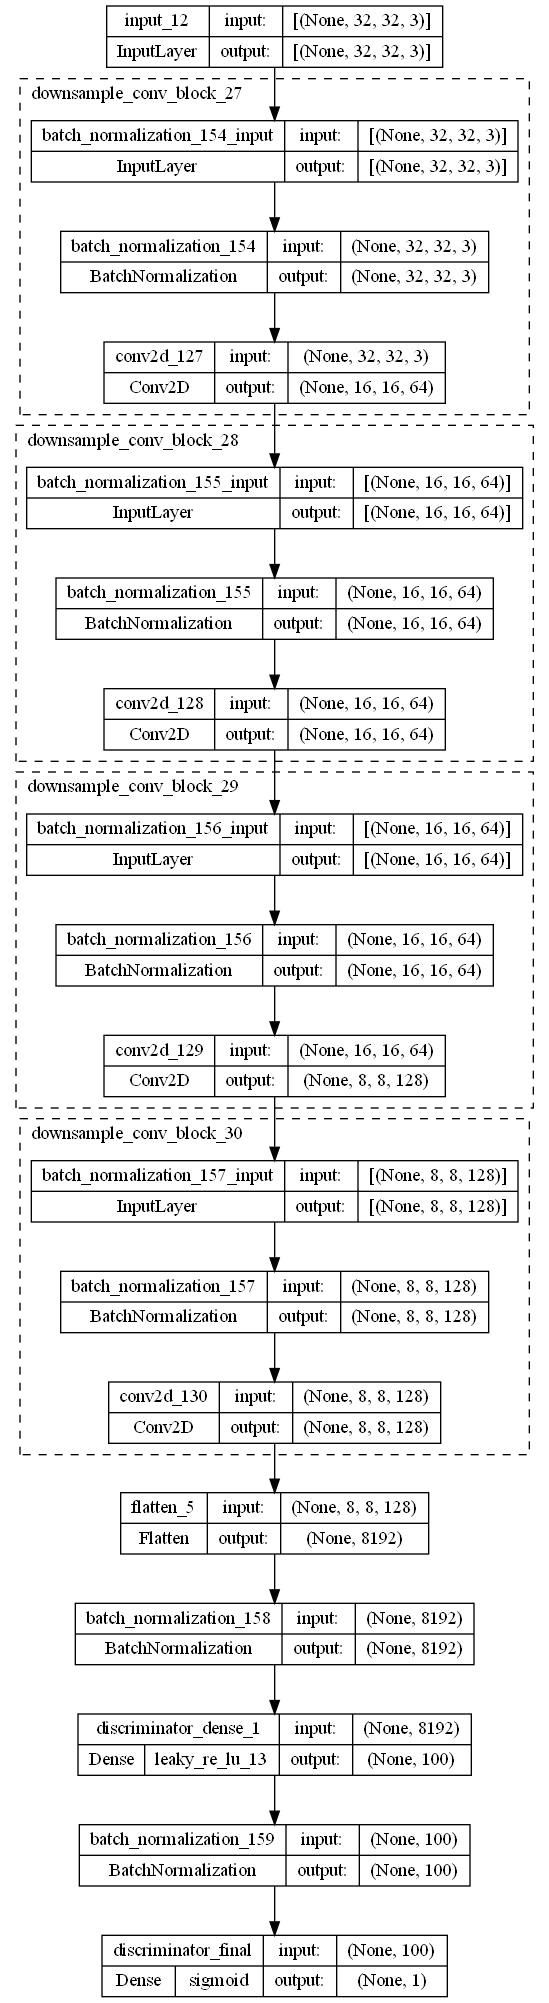

In [ ]:
discriminator = keras.Sequential(name="discriminator")
discriminator.add(keras.Input(shape=(32, 32, 3)))

discriminator.add(conv_block(64, use_bn=True))
discriminator.add(conv_block(64, stride=1, use_bn=True))
discriminator.add(conv_block(128, use_bn=True))
discriminator.add(conv_block(128, stride=1, use_bn=True))
discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.BatchNormalization())
discriminator.add(
    keras.layers.Dense(
        100, activation=keras.layers.LeakyReLU(alpha=0.2), name="discriminator_dense_1"
    )
)

discriminator.add(keras.layers.BatchNormalization())
discriminator.add(keras.layers.Dense(1, activation="sigmoid", name="discriminator_final"))

plot_model(discriminator, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
discriminator.summary(expand_nested=True)

# 1.1mil params

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 downsample_conv_block_27 (S  (None, 16, 16, 64)       1804      
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_154 (Ba  (None, 32, 32, 3)      12        |
| tchNormalization)                                             |
|                                                               |
| conv2d_127 (Conv2D)       (None, 16, 16, 64)        1792      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 downsample_conv_block_28 (S  (None, 16, 16, 64)       37184     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_155 (Ba  (None, 16, 16, 64)     256       |
| tchNormalization)                                  

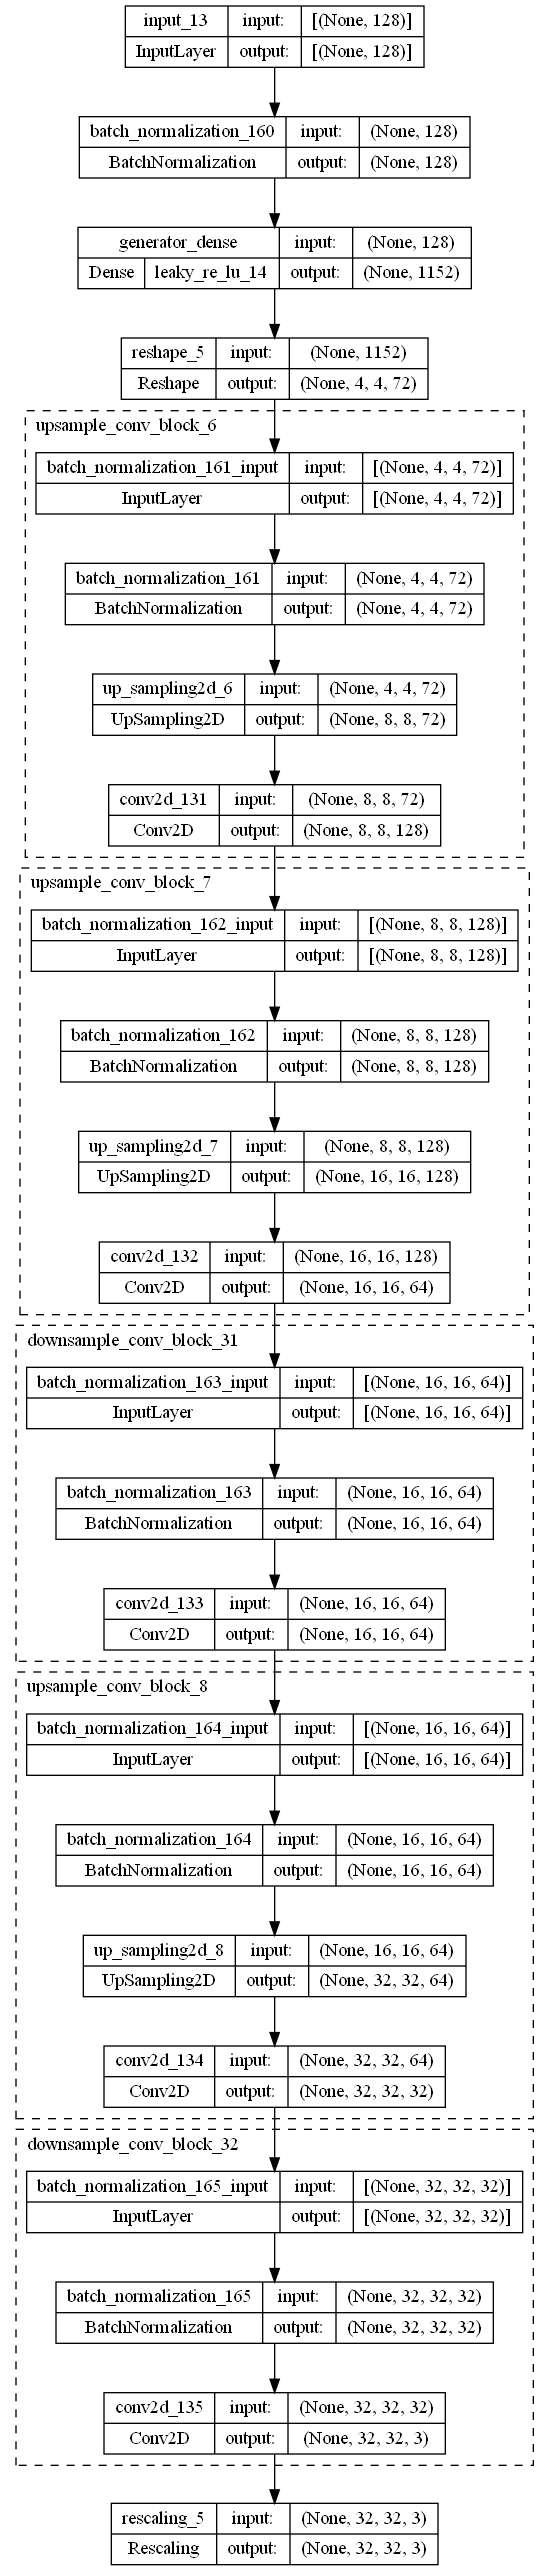

In [ ]:
generator = keras.Sequential(name="generator")
generator.add(keras.Input(shape=(128,)))

generator.add(keras.layers.BatchNormalization())
generator.add(
    keras.layers.Dense(
        4 * 4 * 72,
        activation=keras.layers.LeakyReLU(alpha=0.2),
        name="generator_dense",
    )
)
generator.add(keras.layers.Reshape((4, 4, 72)))

generator.add(conv_upsample_block(128, use_bn=True))
generator.add(conv_upsample_block(64, use_bn=True))
generator.add(conv_block(64, stride=1, use_bn=True))
generator.add(conv_upsample_block(32, use_bn=True))
generator.add(conv_block(3, stride=1, activation="tanh", use_bn=True))

#output range 0 to 1
generator.add(keras.layers.Rescaling(scale=0.5, offset=0.5))

plot_model(generator, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
generator.summary(expand_nested=True)

# 363k params

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_160 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 generator_dense (Dense)     (None, 1152)              148608    
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 72)          0         
                                                                 
 upsample_conv_block_6 (Sequ  (None, 8, 8, 128)        83360     
 ential)                                                         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_161 (Ba  (None, 4, 4, 72)       288       |
| tchNormalization)                                             |
|                                                        

1/1 [==============================] - 0s 135ms/step
Discriminator score: [0.09068705]


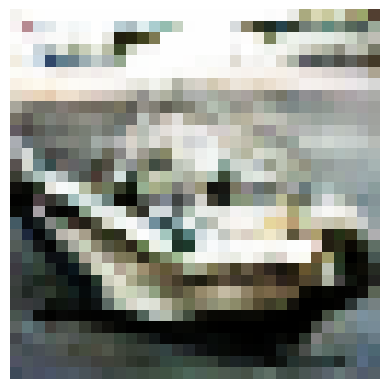

In [ ]:
gan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=wandb.config.latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=wandb.config.lr),
    g_optimizer=keras.optimizers.Adam(learning_rate=wandb.config.lr),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.compute_output_shape(input_shape=(None, wandb.config.latent_dim, 1))

gan.load_weights("./chkpts/upsample_discriminator/120-1606.5")


random_vector = tf.random.normal(shape=(1, wandb.config.latent_dim))
generated_image = gan.generator.predict(random_vector)
discriminator_score = gan.discriminator.predict(generated_image)
print("Discriminator score:", discriminator_score[0])
plt.imshow(generated_image[0])
plt.grid(False)
plt.axis(False)
plt.show()

### Training

In [ ]:
BATCH_SIZE = 100
EPOCHS = 30

history_df = pd.read_csv(f"histories/{model_name}.csv")
EPOCHS_TRAINED = len(history_df)
EPOCHS_TRAINED

120

In [ ]:
history = gan.fit(
    sharpened_images,
    epochs=EPOCHS_TRAINED + EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        GeneratorImageLogger(
            logdir=f"images/{model_name}/",
            latent_dim=wandb.config.latent_dim,
            log_freq=5,
        ),
        FIDLogger(latent_dim=wandb.config.latent_dim, log_freq=5),
        WandbMetricsLogger(),
        WandbEpochModelCheckpoint(
            filepath=f"chkpts/{model_name}/" + "{epoch:03d}-{fid:.1f}",
            frequency=5,
            save_weights_only=True,
        ),
        keras.callbacks.CSVLogger(
            f"histories/{model_name}.csv", append=bool(EPOCHS_TRAINED)
        ),
    ],
    initial_epoch=EPOCHS_TRAINED,
)

history_df = pd.read_csv(f"histories/{model_name}.csv")
EPOCHS_TRAINED = len(history_df)
EPOCHS_TRAINED

Epoch 121/150
600/600 [==============================] - 56s 89ms/step - d_loss: 0.9068 - g_loss: 1.8794 - fid: nan
Epoch 122/150
600/600 [==============================] - 53s 89ms/step - d_loss: 0.9024 - g_loss: 1.8847 - fid: nan
Epoch 123/150
600/600 [==============================] - 53s 89ms/step - d_loss: 0.8991 - g_loss: 1.9002 - fid: nan
Epoch 124/150
600/600 [==============================] - 53s 89ms/step - d_loss: 0.8954 - g_loss: 1.9089 - fid: nan
Epoch 125/150
600/600 [==============================] - 67s 112ms/step - d_loss: 0.8910 - g_loss: 1.9269 - fid: 1584.1202
Epoch 126/150
600/600 [==============================] - 53s 89ms/step - d_loss: 0.8858 - g_loss: 1.9511 - fid: nan
Epoch 127/150
600/600 [==============================] - 53s 89ms/step - d_loss: 0.8834 - g_loss: 1.9483 - fid: nan
Epoch 128/150
600/600 [==============================] - 53s 89ms/step - d_loss: 0.8853 - g_loss: 1.9656 - fid: nan
Epoch 129/150
600/600 [==============================] - 53s 89ms

150

In [ ]:
wandb.finish()

FID,▁▇▅█▆▁
epoch/d_loss,▅▆▅▅▅▄▄▄▆▄▃▇▃▃▃▆▄▄▄▇▃▄▆▂▃▃█▁▃▄
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/fid,▁ ▇ ▅ █ ▆ ▁
epoch/g_loss,▃▁▃▃▅▄▂▅▂▄▆▄▅█▆▂▆▅▃▅▅▃▇▆▄▄▄▄▄▇
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
FID,1587.28324
epoch/d_loss,0.85001
epoch/epoch,149
epoch/fid,1587.28324
epoch/g_loss,2.30656


### Evaluation